In [1]:
!pip install gpxpy
!pip install lxml

In [1]:
import gpxpy
import pandas as pd
import glob
import xml.etree.ElementTree as ET

X = []
y = []

import glob

gpxList = glob.glob('activities/*.gpx')

LIMIT = 200
for file_path in gpxList:
    tree = ET.parse(file_path)

    root = tree.getroot()

    type = ''
    for type_elem in root.findall(".//{http://www.topografix.com/GPX/1/1}trk/{http://www.topografix.com/GPX/1/1}type"):
        type = type_elem.text

    if type == 'running' or type == 'cycling':
        y.append(type_elem.text)

        with open(file_path) as f:
            gpx = gpxpy.parse(f)
        points = []
        for segment in gpx.tracks[0].segments:
            for p in segment.points:
                points.append([p.latitude, p.longitude, p.elevation])
                if len(points) == LIMIT:
                    break

        X.append(points)

In [385]:
X[0]

[[47.229764, -1.378735],
 [47.229764, -1.378684],
 [47.229773, -1.378638],
 [47.229806, -1.378606],
 [47.229813, -1.378542],
 [47.229814, -1.378475],
 [47.229829, -1.378418],
 [47.229835, -1.378379],
 [47.22986, -1.378318],
 [47.229899, -1.378275],
 [47.229917, -1.378244],
 [47.22993, -1.378205],
 [47.229948, -1.378173],
 [47.229983, -1.378124],
 [47.229996, -1.378087],
 [47.230022, -1.378039],
 [47.230044, -1.377997],
 [47.230041, -1.377951],
 [47.230053, -1.377902],
 [47.230083, -1.377853],
 [47.230103, -1.37781],
 [47.230119, -1.37777],
 [47.230129, -1.377721],
 [47.230149, -1.377679],
 [47.230174, -1.377635],
 [47.230191, -1.377597],
 [47.230207, -1.377558],
 [47.230227, -1.377526],
 [47.230259, -1.377484],
 [47.230287, -1.377466],
 [47.230319, -1.377456],
 [47.230355, -1.377456],
 [47.23039, -1.377463],
 [47.230426, -1.377472],
 [47.230462, -1.377485],
 [47.230497, -1.377496],
 [47.230534, -1.377509],
 [47.230571, -1.377523],
 [47.230608, -1.377541],
 [47.230646, -1.377558],
 [47.

In [15]:
len(X[0])

200

In [387]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_array = pad_sequences(np.array(X), padding='post', dtype='float32')
y_array = np.array(y)


/var/folders/45/s9n1gyr93d511pxxmdwy5rqc0000gn/T/ipykernel_13176/1959684346.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_array = pad_sequences(np.array(X), padding='post', dtype='float32')


In [388]:
X_array[0]

array([[47.229763, -1.378735],
       [47.229763, -1.378684],
       [47.229774, -1.378638],
       ...,
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ],
       [ 0.      ,  0.      ]], dtype=float32)

In [389]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Nous devons appliquer le scaler à chaque séquence individuellement
X_array = np.array([scaler.fit_transform(sequence) for sequence in X_array])


In [390]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Codage à chaud des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_array)
y_categorical = to_categorical(y_encoded)

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X_array, y_categorical, test_size=0.2, random_state=42)

In [391]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construire le modèle
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [392]:
model.fit(X_train, y_train, epochs=10, batch_size=8, verbose=1)

Epoch 1/10


2023-09-20 13:59:06.628108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 13:59:06.777057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
X_predicted = model.predict(X_test)
idx = 0
X_begin = scaler.inverse_transform(X_test[idx])
X_end = scaler.inverse_transform(X_predicted[idx])
X_real_end = scaler.inverse_transform(y_test[idx])

In [21]:
# Évaluer le modèle
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}, Accuracy: {accuracy}")

2023-09-19 13:53:53.812787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 13:53:53.882874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 131ms/step - loss: 0.6159 - accuracy: 0.5926
Loss: 0.6158605217933655, Accuracy: 0.5925925970077515


In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construire le modèle
model = Sequential([
    LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh',return_sequences=True),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    Dropout(0.2),
    Dense(32),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    

In [52]:
model.fit(X_train, y_train, epochs=20, batch_size=8, verbose=1)

Epoch 1/20


2023-09-19 14:17:35.659185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:17:35.933651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:17:36.267628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:17:36.715213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:17:37.398324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/68 [==============================] - 13s 129ms/step - loss: 0.6740 - accuracy: 0.5651
Epoch 2/20
68/68 [==============================] - 7s 100ms/step - loss: 0.6531 - accuracy: 0.6394
Epoch 3/20
68/68 [==============================] - 7s 101ms/step - loss: 0.6261 - accuracy: 0.6487
Epoch 4/20
68/68 [==============================] - 7s 100ms/step - loss: 0.6207 - accuracy: 0.6338
Epoch 5/20
68/68 [==============================] - 7s 100ms/step - loss: 0.6180 - accuracy: 0.6636
Epoch 6/20
68/68 [==============================] - 7s 101ms/step - loss: 0.6039 - accuracy: 0.6506
Epoch 7/20
68/68 [==============================] - 7s 101ms/step - loss: 0.6175 - accuracy: 0.6506
Epoch 8/20
68/68 [==============================] - 7s 102ms/step - loss: 0.5829 - accuracy: 0.6933
Epoch 9/20
68/68 [==============================] - 7s 102ms/step - loss: 0.5583 - accuracy: 0.7026
Epoch 10/20
68/68 [==============================] - 7s 104ms/step - loss: 0.5580 - accuracy: 0.7175
Epoch 11/

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, MaxPooling1D

# Construire le modèle
model = Sequential([
    LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh',return_sequences=True),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compiler le modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    

In [57]:
model.fit(X_train, y_train, epochs=50, batch_size=4, verbose=1)

Epoch 1/50


2023-09-19 14:23:49.412791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:23:49.575876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-19 14:23:50.000115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 11s 65ms/step - loss: 0.6383 - accuracy: 0.6357
Epoch 2/50
135/135 [==============================] - 8s 57ms/step - loss: 0.5318 - accuracy: 0.7193
Epoch 3/50
135/135 [==============================] - 8s 57ms/step - loss: 0.5162 - accuracy: 0.7528
Epoch 4/50
135/135 [==============================] - 8s 58ms/step - loss: 0.4707 - accuracy: 0.7695
Epoch 5/50
135/135 [==============================] - 8s 59ms/step - loss: 0.4767 - accuracy: 0.7546
Epoch 6/50
135/135 [==============================] - 8s 58ms/step - loss: 0.4382 - accuracy: 0.7844
Epoch 7/50
135/135 [==============================] - 8s 58ms/step - loss: 0.4141 - accuracy: 0.7900
Epoch 8/50
135/135 [==============================] - 8s 57ms/step - loss: 0.4083 - accuracy: 0.8067
Epoch 9/50
135/135 [==============================] - 8s 58ms/step - loss: 0.3690 - accuracy: 0.8327
Epoch 10/50
135/135 [==============================] - 8s 57ms/step - loss: 0.3627 - accuracy: 0.8178

In [2]:
import gpxpy
import pandas as pd
import glob
import xml.etree.ElementTree as ET

X = []
y = []

import glob

gpxList = glob.glob('activities/*.gpx')

for file_path in gpxList:
    tree = ET.parse(file_path)

    root = tree.getroot()

    type = ''
    for type_elem in root.findall(".//{http://www.topografix.com/GPX/1/1}trk/{http://www.topografix.com/GPX/1/1}type"):
        type = type_elem.text

    if type == 'cycling':
        y.append(type_elem.text)

        with open(file_path) as f:
            gpx = gpxpy.parse(f)
        points = []
        for segment in gpx.tracks[0].segments:
            for p in segment.points:
                points.append([p.latitude, p.longitude])

        X.append(points)

In [3]:
def filter(array):
    return len(array) < 500

filtered = [arr for arr in X if len(arr) > 500]

In [59]:
flattened_data = [point for trajectory in X for point in trajectory]

In [169]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(flattened_data)

In [170]:
index = 0
scaled_data_restructured = []

for trajectory in X:
    length = len(trajectory)
    scaled_trajectory = scaled_data[index:index+length]
    scaled_data_restructured.append(scaled_trajectory)
    index += length

In [171]:
X_array = []
y_array = []

for track in scaled_data_restructured:
    if len(track) >= 500:
        # X_array.append(track[:250]) # [:250]
        # y_array.append(track[250:250+124]) # [250:500]
        X_array.append(track[:250]) # [:250]
        y_array.append(track[249:249+61]) # [250:500]

In [172]:
from sklearn.model_selection import train_test_split

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

In [231]:
len(X_train)

291

In [232]:
len(X_train[0])

250

In [233]:
len(y_train)

291

In [234]:
len(y_train[1])

250

In [173]:
import numpy as np

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)

In [132]:
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM, Dropout, Dense, TimeDistributed, Bidirectional

model = Sequential()

model.add(LSTM(units=50, batch_input_shape=(None, 250, 2),return_sequences=True))

model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(2, activation='linear')))

model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 250, 50)           10600     
                                                                 
 dropout_48 (Dropout)        (None, 250, 50)           0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 250, 100)         40400     
 nal)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 250, 100)          0         
                                                                 
 time_distributed_16 (TimeDi  (None, 250, 2)           202       
 stributed)                                                      
                                                                 
Total params: 51,202
Trainable params: 51,202
Non-tra

In [141]:
history = model.fit(X_train,y_train,epochs=50, batch_size=8, validation_data=(X_test,y_test))

Epoch 1/50


2023-09-20 16:02:46.624018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:47.052199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:47.303225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:47.316668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:47.883960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:47.905402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:02:48.590778: I tensorflow/core/grappler/optimizers/cust

ValueError: Creating variables on a non-first call to a function decorated with tf.function.

In [256]:
# 0,41 avec 250 premiers points et 250 suivant

In [174]:
from tensorflow.keras.layers import TimeDistributed, Bidirectional,Conv1D, MaxPooling1D

model = Sequential()

# Couche de convolution
model.add(Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=(250, 2)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='tanh', input_shape=(250, 2)))
model.add(MaxPooling1D(pool_size=2))

# Couches LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Dense(units=20, activation='tanh'))
model.add(Dropout(0.2))

# Couche de sortie
model.add(TimeDistributed(Dense(2, activation='linear')))

# Compilation du modèle
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 248, 64)           448       
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 124, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 122, 128)          24704     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 61, 128)          0         
 g1D)                                                            
                                                                 
 lstm_56 (LSTM)              (None, 61, 50)            35800     
                                                                 
 dropout_65 (Dropout)        (None, 61, 50)          

In [175]:
history = model.fit(X_train,y_train,epochs=100, batch_size=8, validation_data=(X_test,y_test))

# 0.6918 avec relu
# 0.7427 avec tanh
# pas mieux avec dim=100 pour lstm

#https://www.sciencedirect.com/science/article/pii/S092523122100134X

Epoch 1/100


2023-09-20 16:33:59.754676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:00.255741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:00.495454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:00.509332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:01.099524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:01.120690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:01.619612: I tensorflow/core/grappler/optimizers/cust

37/37 [==============================] - ETA: 0s - loss: 201.5658 - accuracy: 0.9752

2023-09-20 16:34:07.427833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:07.646130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:07.837216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 16:34:07.847045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


37/37 [==============================] - 11s 195ms/step - loss: 201.5658 - accuracy: 0.9752 - val_loss: 200.5976 - val_accuracy: 1.0000
Epoch 2/100
37/37 [==============================] - 3s 87ms/step - loss: 200.2043 - accuracy: 1.0000 - val_loss: 199.7888 - val_accuracy: 1.0000
Epoch 3/100
37/37 [==============================] - 3s 76ms/step - loss: 199.5280 - accuracy: 1.0000 - val_loss: 199.1163 - val_accuracy: 1.0000
Epoch 4/100
37/37 [==============================] - 3s 76ms/step - loss: 199.0118 - accuracy: 1.0000 - val_loss: 198.6172 - val_accuracy: 1.0000
Epoch 5/100
37/37 [==============================] - 3s 77ms/step - loss: 198.5832 - accuracy: 1.0000 - val_loss: 198.1816 - val_accuracy: 1.0000
Epoch 6/100
37/37 [==============================] - 3s 74ms/step - loss: 198.1692 - accuracy: 1.0000 - val_loss: 197.7681 - val_accuracy: 1.0000
Epoch 7/100
37/37 [==============================] - 3s 77ms/step - loss: 197.7724 - accuracy: 1.0000 - val_loss: 197.3652 - val_accur

In [176]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

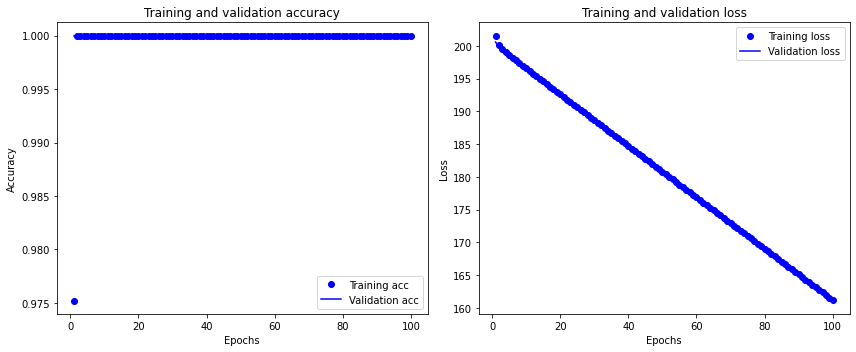

In [177]:
import matplotlib.pyplot as plt

# Graphique pour l'accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Graphique pour la loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [178]:
X_predicted = model.predict(X_test)
idx = 50
X_begin = scaler.inverse_transform(X_test[idx])
X_end = scaler.inverse_transform(X_predicted[idx])
X_real_end = scaler.inverse_transform(y_test[idx])

# X_begin = X_test[idx]
# X_end = X_predicted[idx]
# X_real_end = y_test[idx]

2023-09-20 17:06:49.797407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 17:06:49.985238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 17:06:50.109405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-09-20 17:06:50.119272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 1s 197ms/step


In [51]:
scaler.transform([[42,1]])

array([[-379.50471112,  234.42385888]])

In [350]:
%pip install folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [179]:
import folium

# Créer une carte centrée autour du premier point du chemin
m = folium.Map(location=X_end[0], zoom_start=14)

# Ajouter une ligne pour le chemin parcouru
folium.PolyLine(X_begin, color="green", weight=2.5, opacity=1).add_to(m)
folium.PolyLine(X_end, color="blue", weight=2.5, opacity=1).add_to(m)
folium.PolyLine(X_real_end, color="red", weight=2.5, opacity=1).add_to(m)

# Afficher la carte
m.save('chemin_parcouru.html')